In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
x = loadmat('mnist_all.mat')

In [2]:
print(x.keys())

dict_keys(['__header__', '__version__', '__globals__', 'train0', 'test0', 'train1', 'test1', 'train2', 'test2', 'train3', 'test3', 'train4', 'test4', 'train5', 'test5', 'train6', 'test6', 'train7', 'test7', 'train8', 'test8', 'train9', 'test9'])


In [3]:
print(len(x['train0']))
print(len(x['train1']))
print(len(x['train0'])+len(x['train1']))
print(len(x['test0']))
print(len(x['test1']))
print(len(x['test0'])+len(x['test1']))

5923
6742
12665
980
1135
2115


In [4]:
Y=np.zeros((1,12665))

In [5]:
for i in range(5923,12665):
    Y[0,i]=1

In [6]:
X=np.zeros((784,12665))

In [7]:
for j in range(12665):
    for i in range(784):
        if j < 5923:
            X[i,j]=x['train0'][j][i]
        else:
            X[i,j]=x['train1'][j-5923][i]

In [8]:
X/=255

In [9]:
Ytest=np.zeros((1,2115))
for i in range(980,2115):
    Ytest[0,i]=1
Xtest=np.zeros((784,2115))
for j in range(2115):
    for i in range(784):
        if j < 980:
            Xtest[i,j]=x['test0'][j][i]
        else:
            Xtest[i,j]=x['test1'][j-980][i]
Xtest/=255

In [10]:
def initialize_parameters_deep(layer_dims):
    
    parameters = {}
    L = len(layer_dims)     # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l-1], layer_dims[l]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l-1], layer_dims[l]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

In [11]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = np.dot(W.T,A_prev)+b,(A_prev, W, b)
        A, activation_cache = 1/(1+np.exp(-Z)),Z
    
    assert (A.shape == (W.T.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [12]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2       # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "sigmoid")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [13]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    logprobs1 = np.multiply(np.log(AL),Y)
    cost1 = -np.sum(logprobs1) 
    logprobs2 = np.multiply(np.log(1-AL),1-Y)
    cost2 = -np.sum(logprobs2)
    cost = (1/m)*(cost1+cost2)
    
    cost = np.squeeze(cost)     
    assert(cost.shape == ())
    
    return cost

In [14]:
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(A_prev,dZ.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W,dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [15]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
        
    if activation == "sigmoid":
        A=1/(1+np.exp(-1*activation_cache))
        dZ = dA*A*(1-A)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [16]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation = "sigmoid")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [17]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads["db" + str(l+1)]
    return parameters

In [18]:
def L_layer_model(d, X1, Y1, learning_rate = 0.1, num_iterations = 3000, print_cost=False, plot_graph=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    
    costs = []  
    
    layers_dims = [784]
    for i in range(d):
        layers_dims.append(50)                           #50 nodes in our hidden layer, H=50
    layers_dims.append(1)
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        indices = np.random.randint(0,12665,size=100)    #We train our model with 100 samples, B=100
        X=X1[:,indices]
        Y=Y1[:,indices]

        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)

        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    
    if plot_graph:
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters, grads

Cost after iteration 0: 0.693028
Cost after iteration 100: 0.682784
Cost after iteration 200: 0.673524
Cost after iteration 300: 0.692479
Cost after iteration 400: 0.690433
Cost after iteration 500: 0.687872
Cost after iteration 600: 0.692791
Cost after iteration 700: 0.695646
Cost after iteration 800: 0.696275
Cost after iteration 900: 0.688762
Cost after iteration 1000: 0.693516
Cost after iteration 1100: 0.683833
Cost after iteration 1200: 0.676582
Cost after iteration 1300: 0.579556
Cost after iteration 1400: 0.156000
Cost after iteration 1500: 0.039988
Cost after iteration 1600: 0.030898
Cost after iteration 1700: 0.013863
Cost after iteration 1800: 0.015090
Cost after iteration 1900: 0.007833
Cost after iteration 2000: 0.011290
Cost after iteration 2100: 0.006732
Cost after iteration 2200: 0.003394
Cost after iteration 2300: 0.007008
Cost after iteration 2400: 0.029303


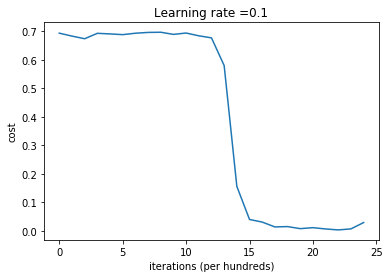

In [19]:
parameters, grads = L_layer_model(2, X, Y, num_iterations = 2500, print_cost = True, plot_graph = True)

In [20]:
def predict(parameters, X):
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = L_model_forward(X, parameters)
    predictions = np.zeros((1,X.shape[1]))
    for i in range(A2.shape[1]):
        if A2[0,i] > 0.5:
            predictions[0,i] = 1
        else:
            predictions[0,i] = 0
    
    return predictions

In [21]:
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 99%


In [22]:
predictions = predict(parameters, Xtest)
print ('Accuracy: %d' % float((np.dot(Ytest,predictions.T) + np.dot(1-Ytest,1-predictions.T))/float(Ytest.size)*100) + '%')

Accuracy: 99%


In [23]:
norm = []
for d in range(1,11):
    parameters, grads = L_layer_model(d, X, Y, num_iterations = 2500)
    norm.append(np.log(np.linalg.norm(grads['dW1'])))

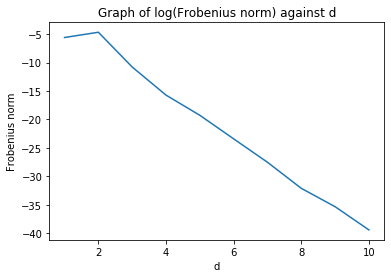

In [24]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.plot(x,norm)
plt.ylabel('Frobenius norm')
plt.xlabel('d')
plt.title("Graph of log(Frobenius norm) against d")
plt.show()

In [25]:
def initialize_parameters_deep1(layer_dims):
    
    parameters = {}
    L = len(layer_dims)     # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l-1], layer_dims[l])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l-1], layer_dims[l]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

In [26]:
def L_layer_model_iteration_1(d, X1, Y1, learning_rate = 0.1, num_iterations = 3000, print_cost=False, plot_graph=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    
    costs = []  
    
    layers_dims = [784]
    for i in range(d):
        layers_dims.append(50)                           #50 nodes in our hidden layer, H=50
    layers_dims.append(1)
    parameters = initialize_parameters_deep1(layers_dims)
    
    indices = np.random.randint(0,12665,size=100)    
    X=X1[:,indices]
    Y=Y1[:,indices]

    AL, caches = L_model_forward(X, parameters)

    cost = compute_cost(AL, Y)

    grads = L_model_backward(AL, Y, caches)

    parameters = update_parameters(parameters, grads, learning_rate)
                
    return parameters, grads

In [27]:
norm = []
for d in range(1,11):
    parameters, grads = L_layer_model_iteration_1(d, X, Y, num_iterations = 2500)
    norm.append(np.log(np.linalg.norm(grads['dW1'])))

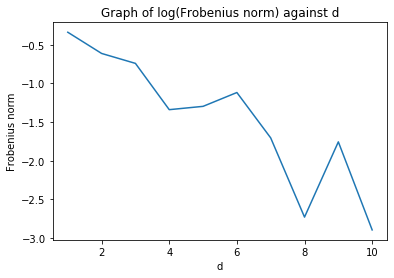

In [28]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.plot(x,norm)
plt.ylabel('Frobenius norm')
plt.xlabel('d')
plt.title("Graph of log(Frobenius norm) against d")
plt.show()